In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/den/dev/git/ozon-e-cup-2025


In [3]:
%matplotlib inline

In [ ]:
from collections import OrderedDict
from multiprocessing import cpu_count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.auto as tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

import src.torch_modules as tm

# Params

In [ ]:
BATCH_SIZE = 256
LOSS_POS_WEIGHT = 10.0

# Load splits

In [ ]:
class MMDataset(Dataset):
    def __init__(self, data_path: Path, is_test: bool = False):
        self.data_path = data_path
        self.is_test = is_test

    def __len__(self):
        return len(list(self.data_path.iterdir()))

    def __getitem__(self, idx):
        file_path = self.data_path / f"{idx}.npy"
        if self.is_test:
            meta_feats, text_tfidf_feats, img_emb, text_emb = np.load(file_path, allow_pickle=True)
            return meta_feats, text_tfidf_feats, img_emb, text_emb

        meta_feats, text_tfidf_feats, img_emb, text_emb, target = np.load(file_path, allow_pickle=True)
        return meta_feats, text_tfidf_feats, img_emb, text_emb, target

In [ ]:
train_dataset = MMDataset(Path("data/train/"))
val_dataset = MMDataset(Path("data/val/"))

In [ ]:
len(train_dataset), len(val_dataset)

(155979, 41219)

# Dataloaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_count())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_count())

In [ ]:
def to_float(batch):
    return [i.float() for i in batch]

Ещё можно попробовать WeightedRandomSampler.

# Train function

In [ ]:
def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Epoch Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Epoch Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label="Val Epoch Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Epoch Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.pause(0.001)


def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs,
    loss_pos_weight,
    save_path,
    prev_history: dict = None,
):
    if prev_history is not None:
        train_losses = prev_history["train_losses"]
        val_losses = prev_history["val_losses"]
        start_from_epoch = prev_history["epoch"]
    else:
        train_losses = []
        val_losses = []
        start_from_epoch = 0

    best_val_loss = max(val_losses) if val_losses else float("inf")

    for epoch_idx in range(start_from_epoch, n_epochs):
        print(f"\nEpoch {epoch_idx + 1}/{n_epochs}")

        model.train()
        train_epoch_losses = []
        for batch_idx, batch in enumerate(train_loader):
            batch = to_float(batch)
            optimizer.zero_grad()
            logits = model(batch[:-1])
            loss = F.binary_cross_entropy_with_logits(
                logits.view(-1), batch[-1], pos_weight=torch.tensor(loss_pos_weight)
            )
            loss.backward()
            optimizer.step()
            train_epoch_losses.append(loss.item())
            print(f"  [Train] Batch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

        train_loss = np.mean(train_epoch_losses)
        train_losses.append(train_loss)
        print(f"  [Train] Epoch Loss: {train_loss:.4f}")

        model.eval()
        val_epoch_losses = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                batch = to_float(batch)
                logits = model(batch[:-1])
                loss = F.binary_cross_entropy_with_logits(
                    logits.view(-1), batch[-1], pos_weight=torch.tensor(loss_pos_weight)
                )
                val_epoch_losses.append(loss.item())
                print(f"  [Val] Batch {batch_idx + 1}/{len(val_loader)} - Loss: {loss.item():.4f}")

        val_loss = np.mean(val_epoch_losses)
        val_losses.append(val_loss)
        print(f"  [Val] Epoch Loss: {val_loss:.4f}")

        plot_losses(train_losses, val_losses)
        scheduler.step()

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "epoch": epoch_idx + 1,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                },
                save_path,
            )

    return train_losses, val_losses


def load_model(model, optimizer, scheduler, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]
    train_losses = checkpoint["train_losses"]
    val_losses = checkpoint["val_losses"]
    return epoch, train_losses, val_losses

# MLP

In [ ]:
model = nn.Sequential(
    OrderedDict(
        [
            ("mm_adapter", tm.MultiModalAdapter(input_dims=[102, 100, 512, 384], emb_dim=64, agg="concat")),
            ("mlp", tm.MLPBinaryHead(input_dim=4 * 64)),
        ]
    )
)

In [ ]:
summary(
    model,
    input_data=[[torch.randn(1, 102), torch.randn(1, 100), torch.randn(1, 512), torch.randn(1, 384)]],
)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─MultiModalAdapter: 1-1                 [1, 256]                  --
│    └─ModuleList: 2-1                   --                        --
│    │    └─LinearProjection: 3-1        [1, 64]                   6,720
│    │    └─LinearProjection: 3-2        [1, 64]                   6,592
│    │    └─LinearProjection: 3-3        [1, 64]                   32,960
│    │    └─LinearProjection: 3-4        [1, 64]                   24,768
├─MLPBinaryHead: 1-2                     [1, 1]                    --
│    └─RMSNorm: 2-2                      [1, 256]                  256
│    └─Sequential: 2-3                   [1, 128]                  --
│    │    └─Linear: 3-5                  [1, 128]                  32,896
│    │    └─LeakyReLU: 3-6               [1, 128]                  --
│    │    └─Dropout: 3-7                 [1, 128]                 

In [ ]:
# Testing model shapes (don't forget to re-create train loader)

batch = to_float(next(iter(train_loader)))
res = model(batch[:-1])
res.shape

torch.Size([256, 1])

In [ ]:
# Testing model's forward and backward

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
batch = to_float(next(iter(train_loader)))
res = model(batch[:-1])
loss = F.binary_cross_entropy_with_logits(res.squeeze(), batch[-1], pos_weight=torch.tensor(LOSS_POS_WEIGHT))
loss.backward()
optimizer.step()

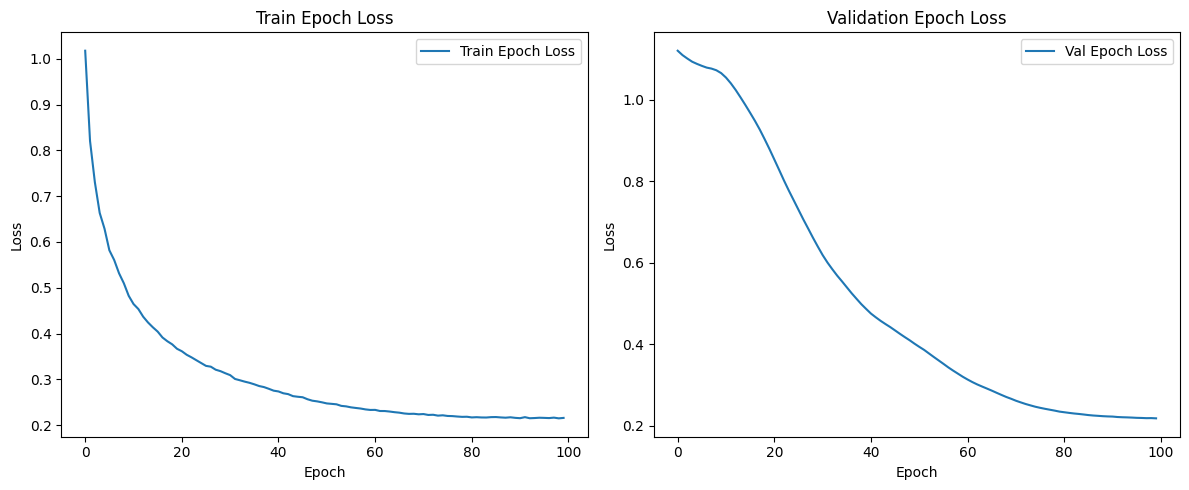

([np.float64(1.0175930261611938),
  np.float64(0.8207055330276489),
  np.float64(0.7305008172988892),
  np.float64(0.6634935140609741),
  np.float64(0.6288754940032959),
  np.float64(0.5818710923194885),
  np.float64(0.5605883002281189),
  np.float64(0.5317339897155762),
  np.float64(0.509813129901886),
  np.float64(0.48253801465034485),
  np.float64(0.46452590823173523),
  np.float64(0.45362526178359985),
  np.float64(0.4368324279785156),
  np.float64(0.4242255687713623),
  np.float64(0.41371068358421326),
  np.float64(0.4042855501174927),
  np.float64(0.3914012908935547),
  np.float64(0.38326847553253174),
  np.float64(0.37652283906936646),
  np.float64(0.36680859327316284),
  np.float64(0.361426442861557),
  np.float64(0.3537450432777405),
  np.float64(0.34810274839401245),
  np.float64(0.34183692932128906),
  np.float64(0.335657000541687),
  np.float64(0.3294532299041748),
  np.float64(0.3277002274990082),
  np.float64(0.3211372494697571),
  np.float64(0.317935973405838),
  np.floa

In [ ]:
# Test model with training on 1 batch

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
batch = next(iter(train_loader))

train(
    model,
    [batch],
    [batch],
    optimizer,
    scheduler,
    n_epochs=100,
    loss_pos_weight=LOSS_POS_WEIGHT,
    save_path="model_weights/mlp_testing_1_batch.pth",
)

In [ ]:
# Train model on full data

N_EPOCHS = 50
BATCH_SIZE = 256
N_JOBS = cpu_count()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_JOBS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_JOBS)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-6)

train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs=N_EPOCHS,
    loss_pos_weight=LOSS_POS_WEIGHT,
    save_path="model_weights/mlp.pth",
)


Epoch 1/50
  [Train] Batch 1/610 - Loss: 3.8780
  [Train] Batch 2/610 - Loss: 3.4155
  [Train] Batch 3/610 - Loss: 0.9752
  [Train] Batch 4/610 - Loss: 2.0072
  [Train] Batch 5/610 - Loss: 1.4540
  [Train] Batch 6/610 - Loss: 1.2761
  [Train] Batch 7/610 - Loss: 1.5554
  [Train] Batch 8/610 - Loss: 1.5031
  [Train] Batch 9/610 - Loss: 1.3202
  [Train] Batch 10/610 - Loss: 1.1564
  [Train] Batch 11/610 - Loss: 1.0314
  [Train] Batch 12/610 - Loss: 0.7929
  [Train] Batch 13/610 - Loss: 0.6834
  [Train] Batch 14/610 - Loss: 0.6985
  [Train] Batch 15/610 - Loss: 0.6505
  [Train] Batch 16/610 - Loss: 0.7875
  [Train] Batch 17/610 - Loss: 0.7847
  [Train] Batch 18/610 - Loss: 0.7839
  [Train] Batch 19/610 - Loss: 0.5800
  [Train] Batch 20/610 - Loss: 0.7102
  [Train] Batch 21/610 - Loss: 0.7861
  [Train] Batch 22/610 - Loss: 0.5538
  [Train] Batch 23/610 - Loss: 0.6098
  [Train] Batch 24/610 - Loss: 0.6130
  [Train] Batch 25/610 - Loss: 0.6415
  [Train] Batch 26/610 - Loss: 0.6688
  [Train]

## Self-attention

In [ ]:
model = tm.MMTransformerEncoder(input_dims=[102, 100, 512, 384], emb_dim=64, num_heads=4, num_layers=4)

In [ ]:
summary(
    model,
    input_data=[[torch.randn(1, 102), torch.randn(1, 100), torch.randn(1, 512), torch.randn(1, 384)]],
)

Layer (type:depth-idx)                        Output Shape              Param #
MMTransformerEncoder                          [1]                       --
├─MultiModalAdapter: 1-1                      [1, 4, 64]                --
│    └─ModuleList: 2-1                        --                        --
│    │    └─LinearProjection: 3-1             [1, 64]                   6,720
│    │    └─LinearProjection: 3-2             [1, 64]                   6,592
│    │    └─LinearProjection: 3-3             [1, 64]                   32,960
│    │    └─LinearProjection: 3-4             [1, 64]                   24,768
├─ModuleList: 1-2                             --                        --
│    └─ModuleList: 2-2                        --                        --
│    │    └─AttentionBlock: 3-5               [1, 4, 64]                16,704
│    │    └─MLPBlock: 3-6                     [1, 4, 64]                49,792
│    └─ModuleList: 2-3                        --                        -

In [ ]:
# Testing model shapes (don't forget to re-create train loader)

batch = to_float(next(iter(train_loader)))
res = model(batch[:-1])
res.shape

torch.Size([256])

In [ ]:
# Testing model's forward and backward

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
batch = to_float(next(iter(train_loader)))
res = model(batch[:-1])
loss = F.binary_cross_entropy_with_logits(res.squeeze(), batch[-1], pos_weight=torch.tensor(LOSS_POS_WEIGHT))
loss.backward()
optimizer.step()

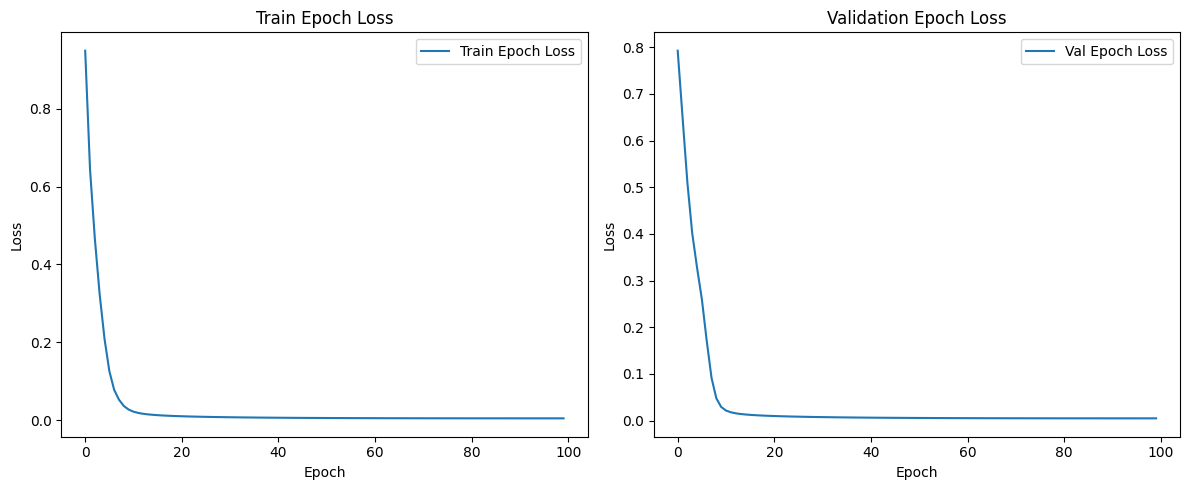

([np.float64(0.9492210745811462),
  np.float64(0.6443562507629395),
  np.float64(0.4656011164188385),
  np.float64(0.3225465416908264),
  np.float64(0.2088272124528885),
  np.float64(0.12593068182468414),
  np.float64(0.07772594690322876),
  np.float64(0.05248505622148514),
  np.float64(0.03639540821313858),
  np.float64(0.027200423181056976),
  np.float64(0.021830031648278236),
  np.float64(0.018573541194200516),
  np.float64(0.01640547625720501),
  np.float64(0.014901502057909966),
  np.float64(0.013810363598167896),
  np.float64(0.012838761322200298),
  np.float64(0.01214609108865261),
  np.float64(0.011507963761687279),
  np.float64(0.010975820943713188),
  np.float64(0.010487525723874569),
  np.float64(0.01010090485215187),
  np.float64(0.009721493348479271),
  np.float64(0.009388858452439308),
  np.float64(0.009076576679944992),
  np.float64(0.008809385821223259),
  np.float64(0.008558104746043682),
  np.float64(0.008310070261359215),
  np.float64(0.008099758997559547),
  np.floa

In [ ]:
# Test model with training on 1 batch

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
batch = next(iter(train_loader))

train(
    model,
    [batch],
    [batch],
    optimizer,
    scheduler,
    n_epochs=100,
    loss_pos_weight=LOSS_POS_WEIGHT,
    save_path="model_weights/transformer_testing_1_batch.pth",
)

In [ ]:
# Train model

N_EPOCHS = 100
BATCH_SIZE = 256
N_JOBS = cpu_count()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_JOBS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_JOBS)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-6)

train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs=N_EPOCHS,
    loss_pos_weight=LOSS_POS_WEIGHT,
    save_path="model_weights/transformer.pth",
)


Epoch 1/100
  [Train] Batch 1/610 - Loss: 1.2199
  [Train] Batch 2/610 - Loss: 1.5975
  [Train] Batch 3/610 - Loss: 0.7793
  [Train] Batch 4/610 - Loss: 0.4781
  [Train] Batch 5/610 - Loss: 0.7315
  [Train] Batch 6/610 - Loss: 0.5688
  [Train] Batch 7/610 - Loss: 0.6357
  [Train] Batch 8/610 - Loss: 0.6175
  [Train] Batch 9/610 - Loss: 0.5485
  [Train] Batch 10/610 - Loss: 0.3839
  [Train] Batch 11/610 - Loss: 0.5078
  [Train] Batch 12/610 - Loss: 0.4363
  [Train] Batch 13/610 - Loss: 0.6715
  [Train] Batch 14/610 - Loss: 0.5477
  [Train] Batch 15/610 - Loss: 0.5165
  [Train] Batch 16/610 - Loss: 0.3955
  [Train] Batch 17/610 - Loss: 0.2869


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x733589fe5460>>
Traceback (most recent call last):
  File "/home/den/miniconda3/envs/ozon-e-cup/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


  [Train] Batch 18/610 - Loss: 0.4021


RuntimeError: DataLoader worker (pid(s) 18234, 18235, 18236, 18237) exited unexpectedly